Helper functions to convert the problem into the appropriate Hamiltonian form.


In [10]:
from pyqubo import Spin, Binary, Array
import math
import numpy as np


def basis_to_gram_matrix(basis):
    if not isinstance(basis, np.ndarray):
        raise ValueError("Basis must be a numpy array")
    
    return basis @ basis.T


def gram_to_quadratic_form(gram_matrix):
    x, y = gram_matrix.shape
    if x != y:
        raise ValueError("Gram matrix must be square")
    
    # Diagonal terms
    diag = {}
    for i in range(x):
        diag[i] = gram_matrix[i, i]
    
    # Off-diagonal terms
    off_diag = {}
    for i in range(x):
        for j in range(i + 1, y):
            off_diag[(i, j)] = gram_matrix[i, j] + gram_matrix[j, i]
    
    return diag, off_diag


def substitution_array(variable_name, num_variables, bounds):
    # Handle bounds input
    if isinstance(bounds, (int, float)):
        bounds = [bounds] * num_variables
    elif len(bounds) != num_variables:
        raise ValueError("Bounds list must match number of variables")
    
    substitutions = []
    
    for i, bound in enumerate(bounds):
        num_bits = math.floor(math.log2(2 * bound)) + 1
        
        # Create binary array for this variable
        binary_vars = Array.create(f"{variable_name}_{i}", shape=num_bits, vartype='BINARY')
        
        # Coefficients for the encoding
        coeffs = [2**j for j in range(num_bits - 1)]
        last_coeff = 2 * bound + 1 - 2**math.floor(math.log2(2 * bound))
        coeffs.append(last_coeff)
        
        # Build the substitution expression
        sub = -bound
        for j, coeff in enumerate(coeffs):
            sub += coeff * binary_vars[j]
        
        substitutions.append(sub)
    print(substitutions)
    return substitutions

def substitution_array_for_nonzero(variable_name, num_variables, bounds):
    if isinstance(bounds, (int, float)):
        bounds = [bounds] * num_variables
    elif len(bounds) != num_variables:
        raise ValueError("Bounds list must match number of variables")
    
    substitutions = []
    
    for i, bound in enumerate(bounds):
        # Calculate number of bits needed
        num_bits = math.floor(math.log2(bound - 1)) + 1
        print(f"Num bits = {num_bits} for bound {bound}")
        
        # Create binary array for this variable
        binary_vars = Array.create(f"{variable_name}_{i}", shape=num_bits + 2, vartype='BINARY')
        
        # x_i = -a_i + ξ_i + ω_i(a + 1) + Σ(2^j * x_ij) + (a_i - 2^⌊log(a_i-1)⌋) * x_i,⌊log(a-1)⌋
        # special encoding hehe
        
        # Build the substitution expression
        sub = -bound  # -a_i term
        
        # ξ_i term (first binary variable)
        sub += binary_vars[0]
        
        # ω_i(a + 1) term (second binary variable)
        sub += binary_vars[1] * (bound + 1)
        
        # Σ(2^j * x_ij) terms for j from 0 to ⌊log(a_i-1)⌋-1
        for j in range(num_bits-1):
            sub += (2**j) * binary_vars[j + 2]
        
        # Final term: (a_i - 2^⌊log(a_i-1)⌋) * x_i,⌊log(a-1)⌋
        if num_bits > 0:
            final_coeff = bound - (2**math.floor(math.log2(bound - 1)))
            sub += final_coeff * binary_vars[num_bits + 1]
            print(f"Appending substitution for {final_coeff} * {binary_vars[num_bits + 1]}")
        substitutions.append(sub)
    print(substitutions)
    return substitutions

def gram_to_hamiltonian(gram_matrix, bounds, variable_name='x'):
    n = gram_matrix.shape[0]
    
    # Convert Gram matrix to quadratic form
    diagonal_terms, off_diagonal_terms = gram_to_quadratic_form(gram_matrix)
    
    # Create substitutions - special non-zero substitution only for x_0
    substitutions = []
    
    for i in range(n):
        # if False: USE THIS IF YOU WANT TO USE THE NORMAL SUBSTITUTION
        if i == 0:
            # Use special non-zero substitution for x_0
            # Extract the bound for this variable and ensure it's a scalar
            if isinstance(bounds, (list, np.ndarray)) and len(bounds) > 1:
                bound_for_i = int(bounds[0])  # Convert to Python int
            else:
                bound_for_i = int(bounds) if isinstance(bounds, np.ndarray) else bounds
            special_sub = substitution_array_for_nonzero(f"{variable_name}_control", 1, bound_for_i)
            substitutions.append(special_sub[0])
        else:
            # Use regular substitution for all other variables
            # Extract the bound for this variable and ensure it's a scalar
            if isinstance(bounds, (list, np.ndarray)) and len(bounds) > 1:
                bound_for_i = int(bounds[i])  # Convert to Python int
            else:
                bound_for_i = int(bounds) if isinstance(bounds, np.ndarray) else bounds
            # FIX: Include the variable index in the variable name
            regular_sub = substitution_array(f"{variable_name}_{i}", 1, bound_for_i)
            substitutions.append(regular_sub[0])
    
    # Build the Hamiltonian
    hamiltonian = 0
    
    
    #IMPORTANT note, I AM ENCODING x_0 AS THE PENALITY INSETAD OF PENALIZING x_0 * x_1 * x_2 * ... * x_n, refer to original paper
    #if you want to penalize the product of all variables instead
    
    # Add penalty for the first binary variable of x_0 (x_control_0) = 1
    # This corresponds to the ξ_0 term in the non-zero encoding
    if len(substitutions) > 0:  # Ensure x_0 exists
        # Create the first binary variable for the penalty
        penalty_var = Binary(f"{variable_name}_control_0[0]")  # First binary var of first special variable
        hamiltonian += 40 * penalty_var  # Penalty of 5 when this binary variable = 1
        #also, 5 is a placeholder, you can change it to whatever you want but you have to ensure that IT IS LARGER THAN THE ACTUAL SVP COST
        # testing_var = Binary(f"{variable_name}_0[0]")  # Second binary var of first special variable
        ## CHANGE THIS TO USE PENALITY VAR, UNCOMMENT THE ABOVE LINES
    
    # Add diagonal terms (quadratic terms like ax²)
    for i, coeff in diagonal_terms.items():
        hamiltonian += coeff * (substitutions[i] ** 2)
    
    # Add off-diagonal terms (cross terms like bxy)
    for (i, j), coeff in off_diagonal_terms.items():
        hamiltonian += coeff * substitutions[i] * substitutions[j]
    
    # Compile the model
    model = hamiltonian.compile()
    return model


def generate_qubo_from_gram_matrix_array(gram_matrix, bounds, variable_name='x'):
    model = gram_to_hamiltonian(gram_matrix, bounds, variable_name)
    qubo_dict, offset = model.to_qubo()
    
    return qubo_dict, offset
def generate_ising_from_gram_matrix_array(gram_matrix, bounds, variable_name='x'):
    model = gram_to_hamiltonian(gram_matrix, bounds, variable_name)
    linear, quadratic, offset = model.to_ising()
    
    return linear , quadratic, offset

def basis_to_ising(basis, bounds, variable_name='x'):
    gram_matrix = basis_to_gram_matrix(basis)
    return generate_ising_from_gram_matrix_array(gram_matrix, bounds, variable_name)

This converts it into the appropriate qiskit forms

In [15]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
import re

def ising_to_sparse_pauli_op(linear_terms, quadratic_terms, offset):
    """
    Convert Ising model terms to SparsePauliOp format.
    
    Args:
        linear_terms: dict with variable names as keys, coefficients as values
        quadratic_terms: dict with (var1, var2) tuples as keys, coefficients as values  
        offset: constant term
    
    Returns:
        SparsePauliOp object
    """
    
    # Extract all variable names and map them to qubit indices
    all_vars = set()
    for var in linear_terms.keys():
        all_vars.add(var)
    for var_pair in quadratic_terms.keys():
        all_vars.update(var_pair)
    
    # Sort variables to ensure consistent ordering
    sorted_vars = sorted(list(all_vars))
    
    print("Sorted variables:", sorted_vars)
    
    # Create mapping from variable name to qubit index
    var_to_qubit = {var: i for i, var in enumerate(sorted_vars)}
    n_qubits = len(sorted_vars)

    
    pauli_list = []
    
    # Add constant term (identity operator)
    if offset != 0:
        identity_string = 'I' * n_qubits
        pauli_list.append([identity_string, offset])
    
    # Add linear terms (single Z operators)
    for var, coeff in linear_terms.items():
        pauli_string = ['I'] * n_qubits
        qubit_idx = var_to_qubit[var]
        pauli_string[qubit_idx] = 'Z'
        pauli_list.append([''.join(pauli_string), coeff])
    
    # Add quadratic terms (ZZ operators)
    for (var1, var2), coeff in quadratic_terms.items():
        pauli_string = ['I'] * n_qubits
        qubit_idx1 = var_to_qubit[var1]
        qubit_idx2 = var_to_qubit[var2]
        pauli_string[qubit_idx1] = 'Z'
        pauli_string[qubit_idx2] = 'Z'
        pauli_list.append([''.join(pauli_string), coeff])
    
    return SparsePauliOp.from_list(pauli_list)

basis = np.array([[-5, -2, 2], [-2, 5, 7], [6, -1, 6]]) #random instances
basis = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
bound = np.array([3,3,3])
ising = basis_to_ising(basis, bound)


print("Raw ising output:")
print(ising)
print()

# Unpack the result
linear_terms, quadratic_terms, offset = ising

# DEBUG: Print the linear and quadratic terms
print("Linear terms:", linear_terms)
print("Quadratic terms:", list(quadratic_terms.keys()))  # Show keys
print("Offset:", offset)
print()

# Convert to SparsePauliOp
ising_op =  ising_to_sparse_pauli_op(linear_terms, quadratic_terms, offset)
print("SparsePauliOp:") #comment this out if dont need debug
print(ising_op)

Num bits = 2 for bound 3
Appending substitution for 1 * Binary('x_control_0[3]')
[((1.000000 * Binary('x_control_0[3]')) + (1.000000 * Binary('x_control_0[2]')) + (Binary('x_control_0[1]') * 4.000000) + -3.000000 + Binary('x_control_0[0]'))]
[((3.000000 * Binary('x_1_0[2]')) + (2.000000 * Binary('x_1_0[1]')) + -3.000000 + (1.000000 * Binary('x_1_0[0]')))]
[((3.000000 * Binary('x_2_0[2]')) + (2.000000 * Binary('x_2_0[1]')) + -3.000000 + (1.000000 * Binary('x_2_0[0]')))]
Raw ising output:
({'x_control_0[0]': 20.5, 'x_control_0[2]': 0.5, 'x_control_0[3]': 0.5, 'x_control_0[1]': 2.0}, {('x_1_0[0]', 'x_1_0[2]'): 1.5, ('x_2_0[0]', 'x_2_0[2]'): 1.5, ('x_control_0[0]', 'x_control_0[2]'): 0.5, ('x_2_0[0]', 'x_2_0[1]'): 1.0, ('x_2_0[1]', 'x_2_0[2]'): 3.0, ('x_control_0[1]', 'x_control_0[2]'): 2.0, ('x_1_0[0]', 'x_1_0[1]'): 1.0, ('x_control_0[0]', 'x_control_0[1]'): 2.0, ('x_control_0[0]', 'x_control_0[3]'): 0.5, ('x_control_0[1]', 'x_control_0[3]'): 2.0, ('x_1_0[1]', 'x_1_0[2]'): 3.0, ('x_contro

=== Fixed QAOA Implementation ===
QAOA circuit has 6 parameters
Circuit depth: 25
Number of qubits: 10
Initial parameters: [0.14812458 0.40453386 0.17512626 0.39470463 0.28067449 0.12679448]
Testing objective function...
Initial energy: 25.590
Starting optimization...

COBYLA hit max iterations, trying Powell method...
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  500   F = 1.982440E+01    MAXCV = 0.000000E+00
   X = 1.655789E-01   4.097913E-01   2.495131E-01   5.038239E-01   1.498048E-01
       1.743571E-01

Optimization terminated successfully.
         Current function value: 6.535815
         Iterations: 18
         Function evaluations: 1279

Optimization completed!
Success: True
Optimal energy: 6.536
Energy improvement: 19.054
Message: Optimization terminated successfully.

Proceeding with sampling (energy improved significantly)...
Sampling from optimized state...

Top 10 most frequent solutions:
 1. 0101011100:  60 counts (6.0%), cost

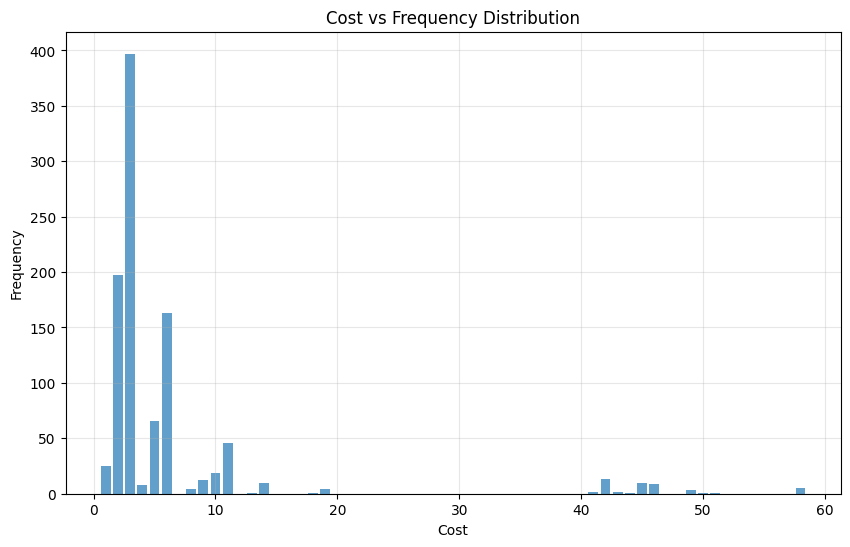

In [17]:
import numpy as np
from qiskit.circuit.library import QAOAAnsatz #Defines the starting point for QAOA circuits
from qiskit.primitives import StatevectorEstimator, StatevectorSampler #Whats the difference?
from scipy.optimize import minimize #COBYLA and Powell optimization methods
import matplotlib.pyplot as plt #plotting results

def create_qaoa_circuit(cost_operator, reps=1):
    
    return QAOAAnsatz(
        cost_operator=cost_operator,
        reps=reps,
        flatten=True  
    )

def create_sampling_circuit(qaoa_ansatz, parameters):
    """Create circuit with measurements for final sampling"""
    bound_circuit = qaoa_ansatz.assign_parameters(parameters)
    bound_circuit.measure_all()
    return bound_circuit

def objective_function_fixed(parameters, qaoa_ansatz, cost_operator):
    """Fixed objective function using StatevectorEstimator"""
    estimator = StatevectorEstimator()
    
    # Handle layout for hardware compatibility
    if hasattr(qaoa_ansatz, 'layout') and qaoa_ansatz.layout is not None:
        isa_hamiltonian = cost_operator.apply_layout(qaoa_ansatz.layout)
    else:
        isa_hamiltonian = cost_operator
    
    # Use the pub format
    pub = (qaoa_ansatz, isa_hamiltonian, parameters)
    job = estimator.run([pub])
    results = job.result()[0]
    
    return float(results.data.evs)

def run_qaoa_optimization(cost_operator, reps=1, max_iterations=500):
    """Complete QAOA optimization workflow"""
    
    # Create QAOA ansatz (without measurements)
    qaoa_ansatz = create_qaoa_circuit(cost_operator, reps=reps)
    
    print(f"QAOA circuit has {qaoa_ansatz.num_parameters} parameters")
    print(f"Circuit depth: {qaoa_ansatz.depth()}")
    print(f"Number of qubits: {qaoa_ansatz.num_qubits}")
    
    #parameter initialization for QAOA
    np.random.seed(69)
    initial_params = np.random.uniform(0, 0.5, qaoa_ansatz.num_parameters)
    print(f"Initial parameters: {initial_params}")
    
    # Test objective function
    print("Testing objective function...")
    initial_energy = objective_function_fixed(initial_params, qaoa_ansatz, cost_operator)
    print(f"Initial energy: {initial_energy:.3f}")
    
    # Run optimization with multiple methods if needed
    print("Starting optimization...")
    
    # Try COBYLA first (good for QAOA?)
    result = minimize(
        objective_function_fixed,
        initial_params,
        args=(qaoa_ansatz, cost_operator),
        method='COBYLA',
        options={'maxiter': max_iterations, 'disp': True}
    )
    
    # If COBYLA didn't converge, try Powell
    if not result.success and result.nfev >= max_iterations * 0.8:
        print("\nCOBYLA hit max iterations, trying Powell method...")
        result = minimize(
            objective_function_fixed,
            result.x,  # Start from COBYLA result
            args=(qaoa_ansatz, cost_operator),
            method='Powell',
            options={'maxiter': max_iterations//2, 'disp': True}
        )
    
    print(f"\nOptimization completed!")
    print(f"Success: {result.success}")
    print(f"Optimal energy: {result.fun:.3f}")
    print(f"Energy improvement: {initial_energy - result.fun:.3f}")
    print(f"Message: {result.message}")
    
    return result, qaoa_ansatz

def sample_final_results(qaoa_ansatz, optimal_params, shots=1000):
    """Sample from the optimized quantum state"""
    
    # Create sampling circuit with measurements
    sampling_circuit = create_sampling_circuit(qaoa_ansatz, optimal_params)
    
    # Use StatevectorSampler for sampling
    sampler = StatevectorSampler()
    job = sampler.run([sampling_circuit], shots=shots)
    counts = job.result()[0].data.meas.get_counts()
    
    return counts

def evaluate_bitstring_cost(bitstring, cost_operator):
    # """Evaluate the actual cost of a solution bitstring"""
    z_values = [1 if bit == '0' else -1 for bit in bitstring]
    
    cost = 0
    for pauli_string, coeff in zip(cost_operator.paulis, cost_operator.coeffs):
        term_value = 1
        for i, pauli in enumerate(str(pauli_string)):
            if pauli == 'Z':
                term_value *= z_values[i]
        cost += coeff.real * term_value
    
    return cost

def complete_qaoa_workflow(ising_op, reps=1):
    """Complete QAOA workflow"""
    
    # Run optimization
    result, qaoa_ansatz = run_qaoa_optimization(ising_op, reps=reps, max_iterations=500)
    
    # # Even if optimization didn't fully converge, we can still sample results
    print(f"\nProceeding with sampling (energy improved significantly)...")
    
    # Sample from optimized state
    print("Sampling from optimized state...")
    counts = sample_final_results(qaoa_ansatz, result.x, shots=1000)
    
    # Analyze top solutions
    print("\nTop 10 most frequent solutions:")
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    for i, (bitstring, count) in enumerate(sorted_counts[:10]):
        probability = count / 1000
        actual_cost = evaluate_bitstring_cost(bitstring, ising_op)
        print(f"{i+1:2d}. {bitstring}: {count:3d} counts ({probability:.1%}), cost = {actual_cost:.1f}")
    
    print("\nBest solutions by actual cost:")
    cost_sorted = [(bs, cnt, evaluate_bitstring_cost(bs, ising_op)) 
                   for bs, cnt in sorted_counts]
    cost_sorted.sort(key=lambda x: x[2])  # Sort by cost
    # Plot cost vs frequency
    # Create a dictionary to aggregate frequencies by cost
    cost_freq_dict = {}
    for item in cost_sorted:
        cost = item[2]
        freq = item[1]
        cost_freq_dict[cost] = cost_freq_dict.get(cost, 0) + freq
    
    # Convert back to lists
    costs = list(cost_freq_dict.keys())
    frequencies = list(cost_freq_dict.values())
    plt.figure(figsize=(10, 6))
    plt.bar(costs, frequencies, alpha=0.7)
    plt.xlabel('Cost')
    plt.ylabel('Frequency')
    plt.title('Cost vs Frequency Distribution')
    plt.grid(True, alpha=0.3)
    
    
    
    
    
    
    for i, (bitstring, count, cost) in enumerate(cost_sorted[:100]):
        probability = count / 1000
        print(f"{i+1}. {bitstring}: cost = {cost:.1f}, frequency = {count} ({probability:.1%})")
    
    return result, sorted_counts

# Run the complete workflow
print("=== Fixed QAOA Implementation ===")
optimization_result, top_solutions = complete_qaoa_workflow(ising_op, reps=3) # reps represent the depth of the QAOA circuit